#Import The Modules

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, InputLayer,BatchNormalization,Input,Layer,Dropout,Resizing,Rescaling,RandomRotation,RandomFlip
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy , FalsePositives,FalseNegatives,TruePositives,TrueNegatives,Precision,Recall,AUC
from tensorflow.keras.callbacks import Callback,CSVLogger,EarlyStopping,ModelCheckpoint,ReduceLROnPlateau,TensorBoard
from tensorflow.keras.regularizers import L1,L2
from tensorflow.image import flip_left_right,random_flip_up_down,rot90,adjust_brightness,random_saturation,central_crop,adjust_saturation,crop_to_bounding_box,pad_to_bounding_box
import sklearn as sl
from sklearn.metrics import confusion_matrix,roc_curve
import seaborn as sns
import numpy as np
import cv2
# import wandb
# from wandb.keras import WandbCallback
from google.colab import drive

#WanDB

##Login & install

In [ ]:
!pip install wandb

In [ ]:
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


##Initialization

In [ ]:
wandb.init(project="my-malaria-project-for-learn",entity="ruhaan18")

wandb: Currently logged in as: ruhaan18. Use `wandb login --relogin` to force relogin


In [ ]:
wandb.run

##Configuration

In [ ]:
wandb.config = {
    "LEARNING_RATE" : 0.001,
    "N_EPOCHS":10,
    "BATCH_SIZE":128,
    "DROPOUT_RATE":0.0,
    "IM_SIZE":224,
    "REGULARIZATION_RATE":0.0,
    "N_FILTERS":6,
    "KERNEL_SIZE":3,
    "N_STRIDES":1,
    "POOL_SIZE":2,
    "N_DENSE_1":128,
    "N_DENSE_2":32,
}

#Load The Datasets

In [ ]:
dataset, dataset_info = tfds.load('malaria', with_info=True, as_supervised=True, shuffle_files=True, split=['train'])

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27558 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/malaria/1.0.0.incomplete2XMF2T/malaria-train.tfrecord*...:   0%|          …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


#Data Preprocessing

##Data Spliting

In [ ]:
def splits(dataset, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1):
    dataset_size = len(dataset)
    train_dataset = dataset.take(int(train_ratio * dataset_size))
    val_test_dataset = dataset.skip(int(train_ratio * dataset_size))
    val_dataset = val_test_dataset.take(int(val_ratio * dataset_size))
    test_dataset = val_test_dataset.skip(int(test_ratio * dataset_size))
    return train_dataset, val_dataset, test_dataset

In [ ]:
train_data, val_data, test_data = splits(dataset[0])

##Data Analyzing

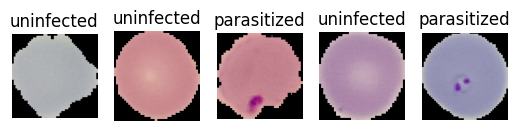

In [ ]:
# Display some images from the training dataset
for i, (image, label) in enumerate(train_data.take(5)):
    ax = plt.subplot(1, 5, i + 1)
    plt.imshow(image)
    plt.title(dataset_info.features['label'].int2str(label))
    plt.axis('off')
plt.show()

##Data Augmantation

###Using the tf.image

In [ ]:
orignal_img ,label= next(iter(train_data))

In [ ]:
def visualize(o_img,a_img):
  plt.subplot(1,2,1)
  plt.imshow(o_img)

  plt.subplot(1,2,2)
  plt.imshow(a_img)

In [ ]:
augmantated_img = central_crop(orignal_img,0.79)

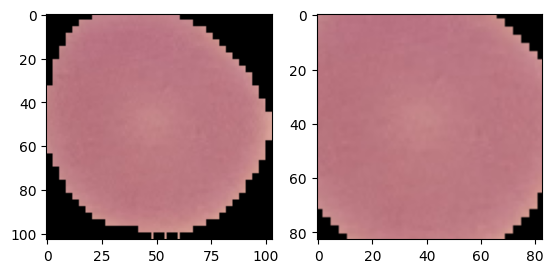

In [ ]:
visualize(orignal_img,augmantated_img)

###Using the tf.keras.layer

In [ ]:
img_size = 224
resize_rescaling_layer = Sequential([
    Resizing(img_size,img_size),
    Rescaling(1.0/255),
])

In [ ]:
augmantation_layer = Sequential([
    RandomRotation(factor = (0.25,0.2501),),
    RandomFlip(mode = 'horizontal',),
])

In [ ]:
img_size = 224
def preprocessing(image, label):
    return tf.image.resize(image, (img_size, img_size)) / 255.0, tf.cast(label, tf.float32)

In [ ]:
img_size = 224
batch_size = 32
def augmantation(image,label):

    return augmantation_layer(resize_rescaling_layer(image),training = True),label


###Convert The Method to Layer Using Class

In [ ]:
class Rot90(Layer):
  def __init__(self):
    super().__init__()
  def call(self,image):
    return rot90(image)

##Mlxup Data Augmentation

In [ ]:
train_data_1 = train_data.shuffle(buffer_size = 8 ,reshuffle_each_iteration = True).map(preprocessing)
train_data_2 = train_data.shuffle(buffer_size = 8 ,reshuffle_each_iteration = True).map(preprocessing)

mix_data = tf.data.Dataset.zip((train_data_1,train_data_2))

In [ ]:
def mixup(train_dataset_1,train_dataset_2):

  (img_1,label_1),(img_2,label_2) = train_dataset_1,train_dataset_2


  lamda = tfp.distributions.Beta(0.2,0.2)
  lamda = lamda.sample(1)[0]

  image = lamda*img_1 + (1-lamda)*img_2
  label = lamda*tf.cast(label_1,dtype = tf.float32) + (1-lamda)*tf.cast(label_2,dtype = tf.float32)
  return image,label

In [ ]:
train_dataset = (
               mix_data
              .shuffle(buffer_size=8,reshuffle_each_iteration = True)
              .map(mixup)
              .batch(32)
              .prefetch(tf.data.AUTOTUNE)
             )

In [ ]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [ ]:
original_image ,label = next(iter(train_data))
plt.imshow(original_image[0])

##Train , Validation and Test Data

In [ ]:
train_data = (
              train_data
              .shuffle(buffer_size=8,reshuffle_each_iteration = True)
              .batch(1)
              .prefetch(tf.data.AUTOTUNE)
              .map(preprocessing)
             )

In [ ]:
val_data = (
              val_data
              .shuffle(buffer_size=8,reshuffle_each_iteration = True)
              .batch(1)
              .prefetch(tf.data.AUTOTUNE)
              .map(preprocessing)
             )

##CutMix Data Augmantation

In [ ]:
##Example
img_size = 224
plt.figure(figsize=(16,8))
plt.subplot(1,9,1)

image_cat = cv2.resize(cv2.imread('cat.jpeg'),(img_size,img_size))
plt.imshow(image_cat)

plt.subplot(1,9,2)
image_dog = cv2.resize(cv2.imread('dog.jpeg'),(img_size,img_size))
plt.imshow(image_dog)

plt.subplot(1,9,3)
image_cat_crop = crop_to_bounding_box(image_cat,20,45,100,98)
plt.imshow(image_cat_crop)

plt.subplot(1,9,4)
image_cat_crop_padding = pad_to_bounding_box(image_cat_crop,20,45,img_size,img_size)
plt.imshow(image_cat_crop_padding)

plt.subplot(1,9,5)
image_dog_crop = crop_to_bounding_box(image_dog,20,45,100,98)
plt.imshow(image_dog_crop)

plt.subplot(1,9,6)
image_dog_crop_padding = pad_to_bounding_box(image_dog_crop,20,45,img_size,img_size)
plt.imshow(image_dog_crop_padding)

plt.subplot(1,9,7)
img = image_dog - image_dog_crop_padding
plt.imshow(img)

plt.subplot(1,9,8)
plt.imshow(img+image_cat_crop_padding)

In [ ]:
def box(lamda):
  r_x= tf.cast(tfp.distributions.Uniform(0, IM_SIZE).sample(1)[0], dtype = tf.int32)
  r_y = tf.cast(tfp.distributions.Uniform(0, IM_SIZE).sample(1)[0], dtype = tf.int32)
  r_w = tf.cast(IM_SIZE*tf.math.sqrt(1-lamda), dtype = tf.int32)
  r_h = tf.cast(IM_SIZE*tf.math.sqrt(1-lamda), dtype = tf.int32)
  r_x = tf.clip_by_value(r_x - r_w//2, 0, IM_SIZE)
  r_y = tf.clip_by_value(r_y - r_h//2, 0, IM_SIZE)
  x_b_r = tf.clip_by_value(r_x + r_w//2, 0, IM_SIZE)
  y_b_r = tf.clip_by_value(r_y + r_h//2, 0, IM_SIZE)
  r_w = x_b_r - r_x
  if(r_w == 0):
  r_w = 1
  r_h = y_b_r - ry
  if(r_h == 0):
  r_h = 1
  return r_y, r_x, r_h, r_w

In [ ]:
def mixup(train_dataset_1,train_dataset_2):

  (img_1,label_1),(img_2,label_2) = train_dataset_1,train_dataset_2

  lamda = tfp.distributions.Beta(0.2,0.2)
  lamda = lamda.sample(1)[0]

  r_y , r_x , r_h , r_w = box(lamda)
  image_1_crop = crop_to_bounding_box(img_1,r_y , r_x , r_h , r_w)
  image_1_crop_padding = pad_to_bounding_box(image_1_crop,r_y,r_x,img_size,img_size)

  image_2_crop = crop_to_bounding_box(img_2,r_y , r_x , r_h , r_w)
  image_2_crop_padding = pad_to_bounding_box(image_2_crop,r_y,r_x,img_size,img_size)

  image = img_1 - image_1_crop_padding + image_2_crop_padding
  return image,label

#Bulding The Models

##WanDB


In [ ]:
Config = wandb.config
DROPOUT_RATE = Config["DROPOUT_RATE"]
IM_SIZE = Config["IM_SIZE"]
REGULARIZATION_RATE = Config["REGULARIZATION_RATE"]
N_FILTERS =Config["N_FILTERS"]
KERNEL_SIZE = Config["KERNEL_SIZE"]
N_STRIDES = Config["N_STRIDES"]
POOL_SIZE = Config["POOL_SIZE"]

# Build the model
lenet_model_1 = Sequential([
    InputLayer(input_shape=(None, None, 3)),
    resize_rescaling_layer,
    Conv2D(filters=8, kernel_size=3, strides=1, padding='valid', activation='relu',kernel_regularizer = L2(l2=0.01,)),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),
    Dropout(rate=DROPOUT_RATE),

    Conv2D(filters=16, kernel_size=3, strides=1, padding='valid', activation='relu',kernel_regularizer = L2(l2=0.01,)),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),

    Flatten(),

    Dense(100, activation='relu',kernel_regularizer = L2(l2=0.01,)),
    BatchNormalization(),
    Dropout(rate=DROPOUT_RATE),

    Dense(10, activation='relu',kernel_regularizer = L2(l2=0.01,)),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
])

lenet_model_1.summary()

##Sequantial API


In [ ]:
imgsize = 224
dropout_rate = 0.3

# Build the model
lenet_model_1 = Sequential([
    InputLayer(input_shape=(None, None, 3)),
    resize_rescaling_layer,
    Conv2D(filters=8, kernel_size=3, strides=1, padding='valid', activation='relu',kernel_regularizer = L2(l2=0.01,)),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),
    Dropout(rate=dropout_rate),

    Conv2D(filters=16, kernel_size=3, strides=1, padding='valid', activation='relu',kernel_regularizer = L2(l2=0.01,)),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),

    Flatten(),

    Dense(100, activation='relu',kernel_regularizer = L2(l2=0.01,)),
    BatchNormalization(),
    Dropout(rate=dropout_rate),

    Dense(10, activation='relu',kernel_regularizer = L2(l2=0.01,)),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
])

lenet_model_1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 8)       224       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 8)       32        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 8)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 111, 111, 8)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)     

##Functional API


In [ ]:
Config = wandb.config
DROPOUT_RATE = Config["DROPOUT_RATE"]
IM_SIZE = Config["IM_SIZE"]
REGULARIZATION_RATE = Config["REGULARIZATION_RATE"]
N_FILTERS =Config["N_FILTERS"]
KERNEL_SIZE = Config["KERNEL_SIZE"]
N_STRIDES = Config["N_STRIDES"]
POOL_SIZE = Config["POOL_SIZE"]

fun_input = Input(shape = (IM_SIZE, IM_SIZE , 3))
x = Conv2D(filters=8, kernel_size=3, strides=1, padding='valid', activation='relu')(fun_input)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=2, strides=2)(x)
x = Conv2D(filters=16, kernel_size=3, strides=1, padding='valid', activation='relu')(x)
x = BatchNormalization()(x)
output = MaxPool2D(pool_size=2, strides=2)(x)

lenet_model_Feature_extractor = Model(fun_input,output)
lenet_model_Feature_extractor.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_10 (Conv2D)          (None, 222, 222, 8)       224       
                                                                 
 batch_normalization_20 (Ba  (None, 222, 222, 8)       32        
 tchNormalization)                                               
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 111, 111, 8)       0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 109, 109, 16)      1168      
                                                                 
 batch_normalization_21 (Ba  (None, 109, 109, 16)      64  

In [ ]:

fun_input = Input(shape = (IM_SIZE, IM_SIZE , 3))

x = lenet_model_Feature_extractor(fun_input)
x = Flatten()(x)

x = Dense(1000, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(100, activation='relu')(x)
x = BatchNormalization()(x)

fun_output = Dense(1, activation='sigmoid')(x)

lenet_model_functional = Model(fun_input,fun_output)
lenet_model_functional.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 model_6 (Functional)        (None, 54, 54, 16)        1488      
                                                                 
 flatten_5 (Flatten)         (None, 46656)             0         
                                                                 
 dense_15 (Dense)            (None, 1000)              46657000  
                                                                 
 batch_normalization_22 (Ba  (None, 1000)              4000      
 tchNormalization)                                               
                                                                 
 dense_16 (Dense)            (None, 100)               100100    
                                                           

##Model Subclassing

In [ ]:
class FeatureExtractor(Layer):
  def __init__(self , filters , kernel_size , strides , padding , activation , pool_size):
    super(FeatureExtractor , self).__init__()

    self.conv_1 = Conv2D(filters = filters, kernel_size = kernel_size , strides = strides, padding = padding, activation = activation)
    self.batch_1 = BatchNormalization()
    self.pool_1 = MaxPool2D(pool_size = pool_size, strides=2*strides)


    self.conv_2 = Conv2D(filters = filters *2, kernel_size = kernel_size , strides = strides, padding = padding, activation = activation)
    self.batch_2 = BatchNormalization()
    self.pool_2 = MaxPool2D(pool_size = pool_size, strides=2*strides)

    def call(self , x , training):

      x = self.conv_1(x)
      x = self.batch_1(x)
      x = self.pool_1(x)

      x = self.conv_2(x)
      x = self.batch_2(x)
      x = self.pool_2(x)

      return x

Feature_Extractor_sub_class = FeatureExtractor( 8 , 3 , 1 , 'valid' , 'relu' , 2)


In [ ]:
class LenetModel(Model):
  def __init__(self):
    super(LenetModel, self).__init__()

    self.Feature_Extractor = FeatureExtractor(8, 3, 1, 'valid', 'relu', 2)

    self.flatten = Flatten()

    self.dense_1 = Dense(100, activation='relu')
    self.batch_1 = BatchNormalization()

    self.dense_2 = Dense(10, activation='relu')
    self.batch_2 = BatchNormalization()

    self.dense_3 = Dense(1, activation='sigmoid')

  def call(self, x, training=False):
    x = self.Feature_Extractor(x, training=training)
    x = self.flatten(x)
    x = self.dense_1(x)
    x = self.batch_1(x, training=training)
    x = self.dense_2(x)
    x = self.batch_2(x, training=training)
    x = self.dense_3(x)
    return x

Lenet_model_with_class = LenetModel()
output = Lenet_model_with_class(tf.zeros([1, 224, 224, 3]))
Lenet_model_with_class.summary()


##Build The our Own Model

In [ ]:
class CustomModel(Layer):
  def __init__(self,output_units , activation):
    super(CustomModel , self).__init__()
    self.output_units = output_units
    self.activation = activation
  def build(self,input_feature_shape):
    self.w = self.add_weight(shape = (input_feature_shape[-1],self.output_units),initializer = "random_normal",trainable = True)
    self.b = self.add_weight(shape = (self.output_units,),initializer = "random_normal",trainable = True)
  def call(self,input_feature):
    pre_output = tf.matmul(input_feature,self.w) + self.b
    if (self.activation == "relu"):
      return tf.nn.relu(pre_output)
    elif (self.activation == "sigmoid"):
        return tf.math.sigmoid(pre_output)
    else:
      return pre_output

In [ ]:
img_size = 224

lenet_custom_model = Sequential([
    InputLayer(input_shape=(img_size, img_size, 3)),
    Conv2D(filters=6, kernel_size=3, strides=1, padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),
    Conv2D(filters=16, kernel_size=3, strides=1, padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),
    Flatten(),
    CustomModel(100, activation='relu'),
    BatchNormalization(),
    CustomModel(10, activation='relu'),
    BatchNormalization(),
    CustomModel(1, activation='sigmoid')
])
lenet_custom_model.summary()

#Model Compilation

##Sequantial

###Custom Loss-Function

In [ ]:
factor = 1
def custom_bce(factor):
  def loss(y_true,y_pred):
    bce = BinaryCrossentropy()
    return bce(y_true,y_pred) *factor
  return loss

###Custom Loss-Function Class

In [ ]:
class CustomBCE(tf.keras.losses.Loss):
  def __init__(self,factor):
    super(CustomBCE , self).__init__()
    self.factor = factor
  def call(self,y_true,y_pred):
    bce = BinaryCrossentropy()
    return bce(y_true,y_pred)*factor

###In Build

In [ ]:
metric = [BinaryAccuracy(name='accuracy'), TruePositives(name='tp'), FalsePositives(name='fp'), TrueNegatives(name='tn'), FalseNegatives(name='fn'), Precision(name='precision'), Recall(name='recall'), AUC(name='AUC')]

In [ ]:
lenet_model_1.compile(optimizer=Adam(learning_rate=Config['LEARNING_RATE']),
                    loss=BinaryCrossentropy(),
                    metrics= metric)

###Custom Metric (accuracy)

In [ ]:
@tf.function
def custom_acc(y_true,y_pred):
  return binary_accuracy(y_true,y_pred)

NameError: name 'tf' is not defined

In [ ]:
factor = 1
def custom_acc(factor):
  def acc(y_true,y_pred):
    return binary_accuracy(y_true,y_pred)*factor
  return acc

###Custom Matric (accuracy) class

In [ ]:
factor = 1
class CustomAcc(tf.keras.metrics.Metric):
  def __init__(self,name = 'Custom_accuracy',factor=1):
    super(CustomAcc,self).__init__()
    self.factor = factor
    self.accuracy = self.add_weigth(name=name,initializer = 'zeros')

  def update_state(self,y_true,y_pred,sample_weight = None):
    output = binary_accuracy(tf.cast(y_true,dtype= tf.float32),y_pred)*self.factor
    self.accuracy.assign(tf.math.count_nonzero(output,dtype=tf.float32)/tf.cast(len(output),dtype= tf.float32))

  def result(self):
    return self.accuracy

  def reset_states(self):
    self.accuracy.assign(0.)

##Functional

In [ ]:
# Compile the model
lenet_model_functional.compile(optimizer=Adam(learning_rate=0.01),
                    loss=BinaryCrossentropy(),
                    metrics=metric)

##Model Subclassing

In [ ]:
Lenet_model_with_class.compile(optimizer=Adam(learning_rate=0.01),
                    loss=BinaryCrossentropy(),
                    metrics='accuracy')

#Custom Model

In [ ]:
lenet_custom_model.compile(optimizer=Adam(learning_rate=0.01),
                    loss=BinaryCrossentropy(),
                    metrics='accuracy')

#CallBacks

##Loss CallBack with Class

In [ ]:
class LossCallback(Callback):
  def on_epoch_end(self,epoch,logs):
    print("\n For Epoch Number {} the loss is {}".format(epoch,logs["loss"]))

##CSVlogger


In [ ]:
csv_callback = CSVLogger(
    'logs.csv' , separator = "," , append = True
)

##EarlyStopping

In [ ]:
es_callback = EarlyStopping(
    monitor = 'val_loss',min_delta = 0,patience = 2,verbose =1,
    mode = 'auto',baseline=None , restore_best_weights=False
)

##Model Check Point

In [ ]:
model_check_point = ModelCheckpoint(
    'checkpoints/', monitor = 'val_loss',verbose = 0,
    save_best_only = True,
    save_weights_only = False,
    mode = 'auto',
    save_freq=3,
    options=None,
    initial_value_threshold=None,
)

##ReduceLROnPlateau

In [ ]:
plateau_call = ReduceLROnPlateau(
    monitor='val_loss',factor=0.1,patience=2,verbose=1
)

##Tensorboard

In [ ]:
tensorboard_callback =  TensorBoard(log_dir="./logs")

#Model Training

##Custom Training Loop

In [ ]:
OPTIMIZER = Adam(learning_rate = 0.01)
METRIC = BinaryAccuracy()
METRIC_VAL = BinaryAccuracy()
EPOCHS = 3

In [ ]:
@tf.function
def training_block(x_batch, y_batch):
  with tf.GradientTape() as recorder:
    y_pred = lenet_model_1(x_batch, training = True)
    loss = custom_bce(y_batch, y_pred)
  partial_derivatives = recorder.gradient(loss, lenet_model_1.trainable_weights)
  OPTIMIZER.apply_gradients(zip(partial_derivatives, lenet_model_1.trainable_weights))
  METRIC.update_state(y_batch, y_pred)
  return loss
@tf.function
def val_block(x_batch_val, y_batch_val):
  y_pred_val = lenet_model_1(x_batch_val, training = False)
  loss_val = custom_bce(y_batch_val, y_pred_val)
  METRIC_VAL.update_state(y_batch_val, y_pred_val)
  return loss_val

In [ ]:
def custom_fit(model,loss_function,METRIC,METRIC_VAL,OPTIMIZER,train_data,val_data,EPOCHS)
  for epoch in range(EPOCHS):
    print("Epoch {}/{}".format(epoch+1,EPOCHS))
    for step, (x_batch, y_batch) in enumerate(train_data):
      loss = training_block(x_batch,y_batch)
    print("Training Loss", loss)
    print("The accuracy is: ", METRIC.result())
    METRIC.reset_states()
    for (x_batch_val, y_batch_val) in val_data:
      loss_val = METRIC.reset_states()
    print("The Validation loss", loss_val)
    print("The Validation accuracy is: ", METRIC_VAL.result())
    METRIC_VAL.reset_states()

##Sequantial

In [ ]:
# Train the model
history = lenet_model_1.fit(train_data, validation_data=val_data, epochs=3, verbose=1 ,callbacks = [WandbCallback()])

##Functional


In [ ]:
# Train the model
history = lenet_model_functional.fit(train_data, validation_data=val_data, epochs=3, verbose=1 ,callbacks = [WandbCallback()])

Epoch 1/3
    4/22046 [..............................] - ETA: 7:42 - loss: 0.7054 - accuracy: 0.5063 - tp: 962.0000 - fp: 910.0000 - tn: 774.0000 - fn: 783.0000 - precision: 0.5139 - recall: 0.5513 - AUC: 0.5016    

22046/22046 [==============================] - 470s 21ms/step - loss: 0.6987 - accuracy: 0.4985 - tp: 6586.0000 - fp: 6594.0000 - tn: 6112.0000 - fn: 6179.0000 - precision: 0.4997 - recall: 0.5159 - AUC: 0.4987 - val_loss: 34.5753 - val_accuracy: 0.4672 - val_tp: 354.0000 - val_fp: 429.0000 - val_tn: 933.0000 - val_fn: 1039.0000 - val_precision: 0.4521 - val_recall: 0.2541 - val_AUC: 0.4618
Epoch 2/3
   22/22046 [..............................] - ETA: 7:08 - loss: 0.6960 - accuracy: 0.5000 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 11.0000 - fn: 11.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.3636

##Model Subclassing

In [ ]:
history = Lenet_model_with_class.fit(train_data, validation_data=val_data, epochs=3, verbose=1)

##Custom Model Training

In [ ]:
history = lenet_custom_model.fit(train_data, validation_data=val_data, epochs=3, verbose=1)

#Visualizations

In [ ]:
Tranfomer

In [ ]:
%load_ext tensorboard

In [ ]:
# log_dir = './logs'
# %tensorboard --logdir = './logs'
!tensorboard --logdir=./logs

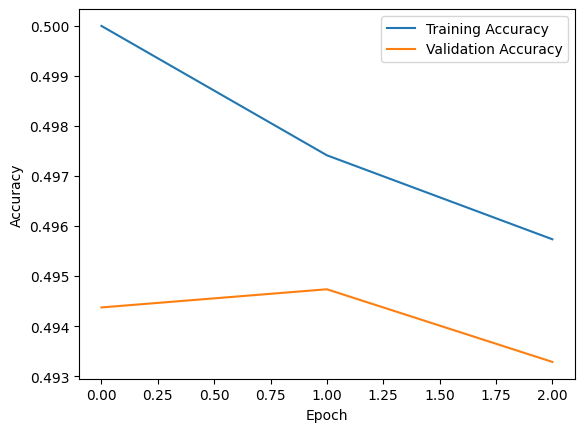

In [ ]:
# Plot training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
# plt.plot(history.history['loss'], label='Training loss')
# plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#Testing The Model

In [ ]:
test_data = test_data.map(preprocessing).batch(1).prefetch(tf.data.AUTOTUNE)

In [ ]:
test_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

##Sequantial Model Evaluation

In [ ]:
lenet_model.evaluate(test_data)

2757/2757 [==============================] - 27s 6ms/step - loss: 2.2287 - accuracy: 0.5053 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 1393.0000 - fn: 1364.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - AUC: 0.6492


[2.228736400604248,
 0.5052593350410461,
 0.0,
 0.0,
 1393.0,
 1364.0,
 0.0,
 0.0,
 0.6492093205451965]

###Visualizing Confusion Matrix

In [ ]:
labels = []
inp = []
for x,y in test_data.as_numpy_iterator():
  labels.append(y)
  inp.append(x)

In [ ]:
print(np.array(labels).shape)
print(np.array(inp).shape)

(2757, 1)
(2757, 1, 224, 224, 3)


In [ ]:
labels = np.array([i[0] for i in labels] , dtype=np.int32)

In [ ]:
print(labels)

[0 0 1 ... 1 1 0]


In [ ]:
predict  = lenet_model.predict(np.array(inp)[:,0,...])

87/87 [==============================] - 1s 15ms/step


In [ ]:
print(predict[:,0])

[0.23532411 0.24065015 0.23927851 ... 0.24141747 0.28750357 0.24119781]


[[   0 1394]
 [   0 1363]]


Text(0.5, 14.722222222222216, 'Predict')

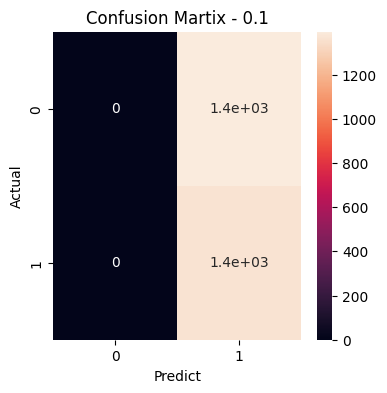

In [ ]:
thresold = 0.1

cm = confusion_matrix(labels,predict > thresold)
print(cm)
plt.figure(figsize=(4,4))
sns.heatmap(cm,annot=True,)
plt.title(f'Confusion Martix - {thresold}')
plt.ylabel('Actual')
plt.xlabel('Predict')

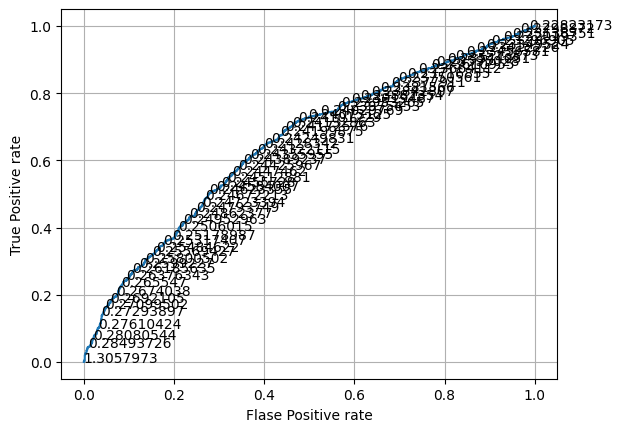

In [ ]:
fp , tp ,thresholds = roc_curve(labels,predict)
plt.plot(fp,tp)
plt.xlabel("Flase Positive rate")
plt.ylabel("True Positive rate")
plt.grid()
skip = 20
for i in range(0,len(thresholds) , skip):
  plt.text(fp[i],tp[i],thresholds[i])
plt.show()

##Functional Model Evaluation

In [ ]:
lenet_model_functional.evaluate(test_data)

2757/2757 [==============================] - 22s 4ms/step - loss: 0.2443 - accuracy: 0.9431


[0.2442609667778015, 0.9430540204048157]

#Predict With Model

In [ ]:
def parasite_or_not(x):
  if(x<0.5):
    return str('P')
  else:
    return str('U')

In [ ]:
parasite_or_not(lenet_model.predict(test_data.take(1))[0][0])

In [ ]:
for i, (image, label) in enumerate(train_data.take(1)):
  ax = plt.subplot(4, 4, i + 1)
  plt.imshow(image[0])
  plt.title(str(parasite_or_not(label.numpy()[0])) + ":" +str(parasite_or_not(lenet_model.predict(image)[0][0])))
  plt.axis('off')



#Use The Model

In [ ]:
image = cv2.imread('images.jpeg')
print(image)


#Save Model

##Save The Full Model

In [ ]:
lenet_model.save("lenetmodel")

In [ ]:
load_lenet_model = tf.keras.models.load_model('lenetmodel')
load_lenet_model.summary()

In [ ]:
lenet_model.save("lenetmodel.hdf5")

##Save The only Weigths

In [ ]:
lenet_model.save_weigths("weigths/lenet_weigths")

##Save in Google Drive

In [ ]:
drive.mount('/content/drive')

In [ ]:
!cp -r /content/lenetmodel /content/drive/MyDrive/lenet_colab

In [ ]:
!cp -r /content/drive/MyDrive/lenet_colab /content/lenetmodel